In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from utils import load_run

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

run = load_run('1638012544')
df = run['data']

# Run the fit
df2 = df.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])
print("DataFrame creation done")
comp_or_var = .85
da_pca = PCA(comp_or_var)
da_scaler = StandardScaler()
df2 = da_pca.fit_transform(df2)
print(f"PCA fit+transform done. Keeping {f'{da_pca.n_components_} features' if comp_or_var < 1 else f'{da_pca.explained_variance_ * 100}% variance'}")
df2 = da_scaler.fit_transform(df2)
print("Scaler fit+transform done")
clust.fit(df2)
print("OPTICS clustering done")

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
print("DBSCAN (0.5) clustering done")
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)
print("DBSCAN (2) clustering done")

space = np.arange(len(df2))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = df2[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(df2[clust.labels_ == -1, 0], df2[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = df2[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(df2[labels_050 == -1, 0], df2[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = df2[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(df2[labels_200 == -1, 0], df2[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

Done loading
Done generating pixel columns
Fitting 1/10 models...
Fitting 2/10 models...
Fitting 3/10 models...
Fitting 4/10 models...
Fitting 5/10 models...
Fitting 6/10 models...
Fitting 7/10 models...
Fitting 8/10 models...
Fitting 9/10 models...
Fitting 10/10 models...


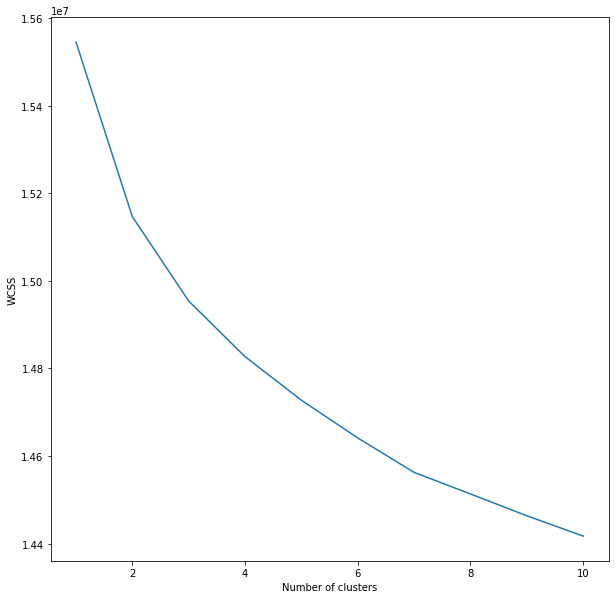

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import extract_first_entries, generate_pixel_columns

file = './dataset/ambulance.ndjson'
df = extract_first_entries(file, recognized=True)
print('Done loading')
df = generate_pixel_columns(df, 32, 1, True)
print('Done generating pixel columns')
x = df.filter(regex=('pixel.+'))
y = df['countrycode']

wcss = []
for i in range(1,11):
   print(f'Fitting model {i}/10...')
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(x)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Done transforming data
Done fitting model
[0 1 2 3 4 5 6]


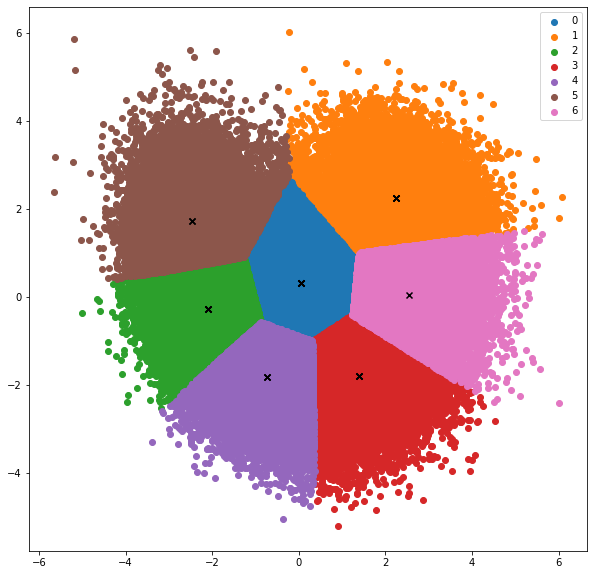

In [6]:
num_clusters = 7
pca = PCA(2)
data = pca.fit_transform(x)
print('Done transforming data')

kmeans = KMeans(n_clusters = num_clusters, init = "k-means++")
model = kmeans.fit_predict(data)
print('Done fitting model')
centers = np.array(kmeans.cluster_centers_)
plt.figure(figsize=(10,10))
uniq = np.unique(model)

for i in uniq:
   plt.scatter(data[model == i , 0] , data[model == i , 1] , label = i)
   plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
plt.legend()
plt.show()